#**Machine Learning and Pattern Recognition**
#Final Project
------------------------------------------------------------------------------
#Automated Detection of Covid-19 with Deep neural networks using X-Ray Images.
#Analysis is done using ResNet-50 Model 
------------------------------------------------------------------------------

## STEP 1: If using Google colab, mount the drive with all the data files required.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
drive.mount('/content/gdrive')


#!ls "/content/gdrive/My Drive"

Mounted at /gdrive
Mounted at /content/gdrive


## STEP 2: Importing the required Libraries
- In Jupyter Notebook, create the environment with all the required libraries.Initially used Anaconda Navigator and directly installed,and set up is made. 

- conda commands on terminal can also be done.

- While using google colab, most of the libraries are already installed. So directly import is done

In [2]:
# Importing basic Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import io

In [3]:
import tensorflow as tf
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import AveragePooling2D, MaxPooling2D, Concatenate
from keras.layers.core import Flatten, Dense, Dropout
from keras import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.utils import plot_model

In [4]:
import cv2
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina'

##STEP 2.1: Checking the Tensorflow Version. If it is above 2.1, this project is fine to work.

In [5]:
# checking the tensorflow version

print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.3.0


##STEP 3: Check the availability of GPU/TPU in order to train the model

- If running in local computer with GPU, this step can be skipped.
- If running in Google colab, ensure this step in order to train the model.

In [6]:
# to check the availability of gpu. 
# Execute in Google colab, if your system does not have GPU
# In Google colab, go to Runtime --> Change Runtime and set it to GPU/TPU accordingly

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## STEP 4: Data Exploration. 
- Ensuring the considered data is clean and categorizing them into groups.

In [7]:
# Checking the training csv file sample

file_1 = pd.read_csv(r"/content/gdrive/My Drive/ML/train_labels.csv")
file_1.head()

,Unnamed: 0,id,label
0,0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
1,1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
2,2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
3,3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
4,4,nejmc2001573_f1a.jpeg,COVID-19


In [10]:
# Checking the testing csv file sample
file_2 = pd.read_csv(r"/content/gdrive/My Drive/ML/test_labels.csv")
file_2.tail()

,Unnamed: 0,id,label
205,86,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,COVID-19
206,36,8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg,COVID-19
207,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
208,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
209,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia


##STEP 5: Loading the Data. 
- the train.csv and test.csv file already has ids and labels to it. 
- Now loading and converting it to Numpy array

In [11]:
def load_data(dir_data, dir_labels, training=True):
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    i = 0
    for identifier in ids:
        if i%800 ==1:
            print(i, end = ' ')
        i+=1
        fname     = dir_data + identifier
        image     = cv2.imread(fname)
        data.append(image)
    # Converting to Numpy array
    data = np.array(data) 
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    pass

##STEP 6: Set the path of the data folder and csv file.

In [13]:

dir_train_images  = '/content/gdrive/My Drive/ML/data/train_resize/'
dir_test_images   = '/content/gdrive/My Drive/ML/data/test_resize/'
dir_train_labels  = '/content/gdrive/My Drive/ML/train_labels.csv'
dir_test_labels   = '/content/gdrive/My Drive/ML/test_labels.csv'

##STEP 7: Splitting Training and validation sets 
- Data Loading and Preprocessing is done here

In [15]:
X_train, y_train = load_data(dir_train_images, dir_train_labels, training=True)

X_train = np.mean(X_train, axis=3)
X_train = X_train.astype(np.uint8)

X_train_rgb = []
for img in X_train:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_train_rgb.append(img_rgb)
X_train_rgb = np.array(X_train_rgb)
#X_train_rgb = X_train #used when disable cv2.color gray2rgb 
X_train_rgb = (X_train_rgb)/255

print('label categorization')
y_train[y_train=='normal']=0
y_train[y_train=='pneumonia']=1
y_train[y_train=='COVID-19']=2

y_train_cat = to_categorical(y_train, num_classes = 3)


# Splitting the training dataset into train/validation set

print('splitting the training and validation set')
from sklearn.model_selection import train_test_split
indxs = np.arange(0, 2625, 1)
X_training, X_val, y_training, y_val, idx_train, idx_val = train_test_split(X_train_rgb, y_train_cat, indxs, test_size=0.4, random_state=1428)

X_training = X_training.reshape(-1,224,224,3)
X_val = X_val.reshape(-1,224,224,3)


1 801 1601 2401 label categorization
splitting the training and validation set


##STEP 8: Checking the Data Loading and Preprocessing

In [16]:
X_test, y_test = load_data(dir_test_images, dir_test_labels, training=True)
X_test = np.mean(X_test, axis=3)
X_test = X_test.astype(np.uint8)
X_test_rgb = []
for img in X_test:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_test_rgb.append(img_rgb)
X_test_rgb = np.array(X_test_rgb)

X_test_rgb = (X_test_rgb)/255

y_test[y_test=='normal']=0
y_test[y_test=='pneumonia']=1
y_test[y_test=='COVID-19']=2
y_test_cat = to_categorical(y_test, num_classes = 3)

1 

##STEP 9: Defining the new ResNet-50 Model

In [17]:
resnet50_pretrained = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

new_model = resnet50_pretrained.output
new_model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(new_model)
new_model = Dropout(0.4)(new_model)#4/8 add droup here
new_model = Flatten(name="flatten")(new_model)
new_model = Dense(3, activation="softmax")(new_model)    

#model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)
model = Model(inputs=resnet50_pretrained.input, outputs=new_model)

94773248/94765736 [==============================] - 4s 0us/step


##STEP 10: Data Augmentation and the Epochs are defined
- Different class weights are considered

In [18]:
BS = 6
EPOCHS = 100

opt = Adam(lr=0.0001, decay=0.01 / (EPOCHS))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

class_weight = {0: 0.1,
                1: 0.1,
                2: 11.}

aug = ImageDataGenerator(ImageDataGenerator(rotation_range=10., width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                         horizontal_flip=True,vertical_flip =True,  fill_mode="nearest"))

##STEP 11.1:Training the model without Early Stopping

In [19]:
np.random.seed(28)
#earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
H = model.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                        validation_data=(X_val, y_val), steps_per_epoch=len(X_training) // BS, epochs=EPOCHS, verbose=1,
                        class_weight = class_weight, callbacks = [mcp_save, reduce_lr_loss])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


262/262 [==============================] - 13s 50ms/step - loss: 0.5687 - accuracy: 0.5061 - val_loss: 2.1561 - val_accuracy: 0.3086
Epoch 2/100
262/262 [==============================] - 11s 43ms/step - loss: 0.1401 - accuracy: 0.7094 - val_loss: 1.9552 - val_accuracy: 0.3124
Epoch 3/100
262/262 [==============================] - 11s 43ms/step - loss: 0.1038 - accuracy: 0.7451 - val_loss: 1.8364 - val_accuracy: 0.4752
Epoch 4/100
262/262 [==============================] - 11s 44ms/step - loss: 0.1169 - accuracy: 0.7960 - val_loss: 0.8536 - val_accuracy: 0.7238
Epoch 5/100
262/262 [==============================] - 10s 40ms/step - loss: 0.2470 - accuracy: 0.6750 - val_loss: 11.6474 - val_accuracy: 0.4981
Epoch 6/100
262/262 [==============================] - 10s 40ms/step - loss: 0.4325 - accuracy: 0.5519 - val_loss: 4.3465 - val_accuracy: 0.5752
Epoch 7/100
262/262 [==============================] - 11s 43ms/step - loss: 0.2540 - accuracy: 0.6176 - val_loss: 0.5924 - val_accuracy: 0.7

##STEP 11.2: Plotting the validation and training accuracy

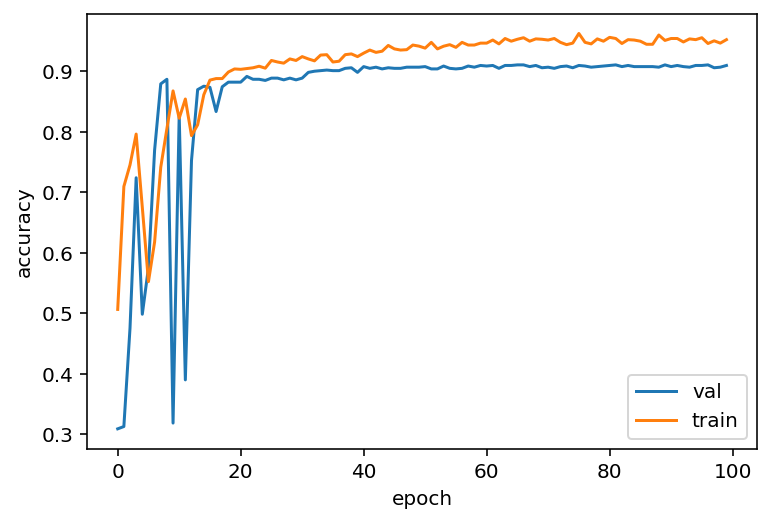

In [20]:
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

## STEP 11.3: Validation performance and accuracy score

In [21]:
'''
Validation
'''
score = model.predict(np.array(X_val))

y_preds = np.argmax(score, axis=1)
ytest = np.argmax(y_val, axis=1)
print(accuracy_score(ytest, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9095238095238095


Predicted,0,1,2,All
True,,,,
0,457,49,5,511
1,31,460,7,498
2,1,2,38,41
All,489,511,50,1050


## STEP 11.4: Training Performance and accuracy score

In [22]:
'''
Train
'''
score = model.predict(np.array(X_train_rgb))

y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_train.astype(int), y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9508571428571428


Predicted,0,1,2,All
True,,,,
0,1194,60,6,1260
1,49,1200,11,1260
2,1,2,102,105
All,1244,1262,119,2625


## STEP 11.5: Training the model with Early Stopping

In [23]:
np.random.seed(28)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
H = model.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                        validation_data=(X_val, y_val), steps_per_epoch=len(X_training) // BS, epochs=EPOCHS, verbose=1,
                        class_weight = class_weight, callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/100
  3/262 [..............................] - ETA: 6s - loss: 0.0058 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


262/262 [==============================] - 12s 45ms/step - loss: 0.0139 - accuracy: 0.9522 - val_loss: 0.2831 - val_accuracy: 0.9086
Epoch 2/100
262/262 [==============================] - 11s 44ms/step - loss: 0.0138 - accuracy: 0.9522 - val_loss: 0.2822 - val_accuracy: 0.9067
Epoch 3/100
262/262 [==============================] - 11s 44ms/step - loss: 0.0137 - accuracy: 0.9496 - val_loss: 0.2813 - val_accuracy: 0.9095
Epoch 4/100
262/262 [==============================] - 10s 39ms/step - loss: 0.0139 - accuracy: 0.9477 - val_loss: 0.2840 - val_accuracy: 0.9067
Epoch 5/100
262/262 [==============================] - 10s 39ms/step - loss: 0.0134 - accuracy: 0.9509 - val_loss: 0.2819 - val_accuracy: 0.9105
Epoch 6/100
262/262 [==============================] - 10s 40ms/step - loss: 0.0138 - accuracy: 0.9496 - val_loss: 0.2853 - val_accuracy: 0.9086
Epoch 7/100
262/262 [==============================] - 10s 39ms/step - loss: 0.0130 - accuracy: 0.9522 - val_loss: 0.2834 - val_accuracy: 0.90

## STEP 11.6: Plotting the validation and training accuracy

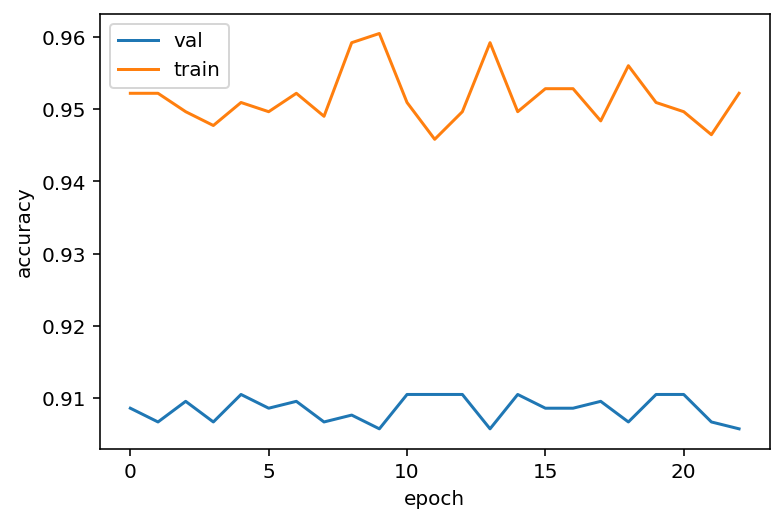

In [24]:
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

## STEP 11.7: Validation Performance and accuracy score

In [25]:
score = model.predict(np.array(X_val))
y_preds = np.argmax(score, axis=1)

ytest = np.argmax(y_val, axis=1)
print(accuracy_score(ytest, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9057142857142857


Predicted,0,1,2,All
True,,,,
0,453,52,6,511
1,31,460,7,498
2,1,2,38,41
All,485,514,51,1050


## STEP 11.8: Training Performance and accuracy score

In [26]:
score = model.predict(np.array(X_train_rgb))
y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_train.astype(int), y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.948952380952381


Predicted,0,1,2,All
True,,,,
0,1189,64,7,1260
1,49,1200,11,1260
2,1,2,102,105
All,1239,1266,120,2625


##STEP 12: Saving the predictions 

In [30]:
'''
score = model.predict(X_train_rgb)
np.savetxt("./scores/resnet50_scores.csv", score, delimiter=",")

y_preds = np.argmax(score, axis=1)

accuracy_score(y_train.ravel(), y_preds)
# confusion_matrix(y_train.ravel(), y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)'''

'\nscore = model.predict(X_train_rgb)\nnp.savetxt("./scores/resnet50_scores.csv", score, delimiter=",")\n\ny_preds = np.argmax(score, axis=1)\n\naccuracy_score(y_train.ravel(), y_preds)\n# confusion_matrix(y_train.ravel(), y_preds)\n\npd.crosstab(y_train, y_preds, rownames=[\'True\'], colnames=[\'Predicted\'], margins=True)'

##STEP 13: Loading Model and Training the saved history

In [ ]:
filename = 'resnet50_92.sav'
history = "hist_resnet50.sav"
loaded_model = pickle.load(open(filename, 'saved_model'))
H = pickle.load(open(history, 'saved_model'))

### Plot training history

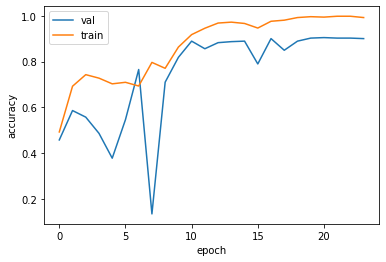

In [ ]:
# training history
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()


##STEP 14:Analyzing the  Performance

In [ ]:
# Train
y_probs_train = loaded_model.predict(np.array(X_train_rgb))
y_preds_train = np.argmax(y_probs_train, axis=1)

In [31]:
y_probs_train = model.predict(np.array(X_train_rgb))
y_preds_train = np.argmax(y_probs_train, axis=1)

In [ ]:
# Validation
y_val = np.argmax(y_val, axis = 1)
y_probs_val = loaded_model.predict(np.array(X_val))
y_preds_val = np.argmax(y_probs_val, axis=1)

In [66]:
y_val = np.argmax(y_val, axis = 1)
y_probs_val = model.predict(np.array(X_val))
y_preds_val = np.argmax(y_probs_val, axis=1)

In [ ]:
# Test
y_probs_test = loaded_model.predict(np.array(X_test_rgb))
y_preds_test = np.argmax(y_probs_test, axis=1)

In [32]:
y_probs_test = model.predict(np.array(X_test_rgb))
y_preds_test = np.argmax(y_probs_test, axis=1)

In [33]:
np.savetxt('y_probs_train.csv', y_probs_train, delimiter = ',')
np.savetxt('y_probs_val.csv', y_probs_val, delimiter = ',')
np.savetxt('y_probs_test.csv', y_probs_test, delimiter = ',')

In [63]:
def plot_cm(ytrue, ypred, title):
    cm = confusion_matrix(ytrue, ypred) 

    cm_df = pd.DataFrame(cm,
                         index = ['normal','pneumonia','COVID-19'], 
                         columns = ['normal','pneumonia','COVID-19'])

    cm_plot = plt.figure(figsize=(8,8))
    sns.heatmap(cm_df, annot=True, annot_kws={"size": 14}, cmap = 'Oranges', fmt='g')
    plt.title('Confusion Matrix {0} Data \nAccuracy:{1:.3f}'.format(title, accuracy_score(ytrue, ypred)), fontsize = 18)
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

### Train

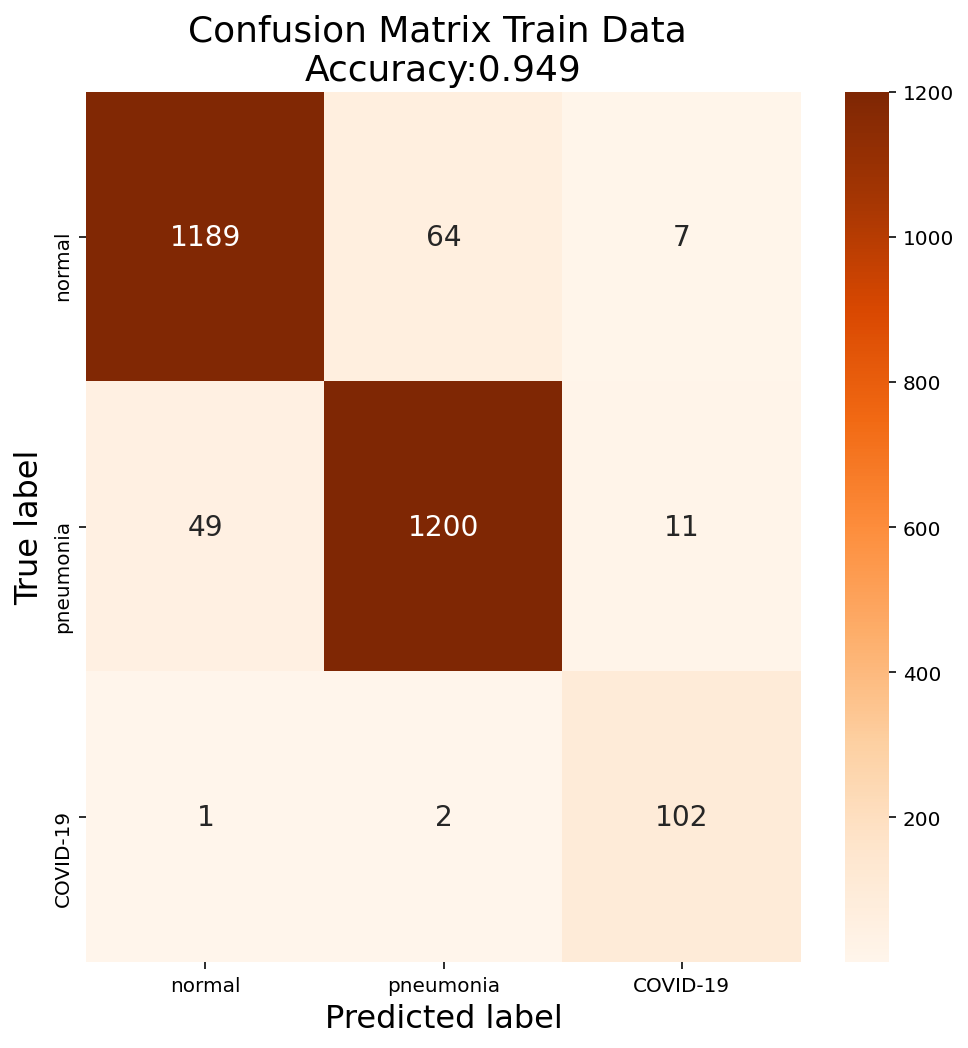

In [64]:

y_train = y_train.astype(int)
plot_cm(y_train, y_preds_train, 'Train')

### Test

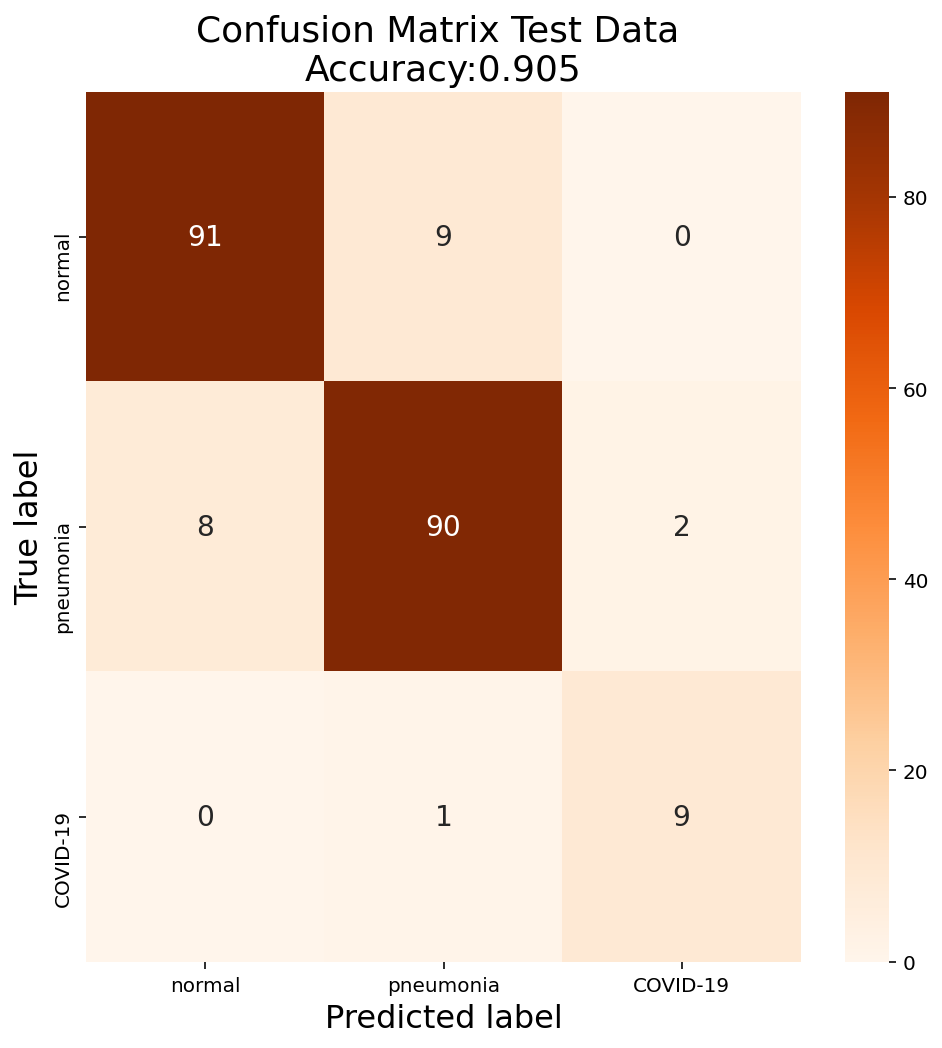

In [68]:
y_test = y_test.astype(int)
plot_cm(y_test, y_preds_test, 'Test')

In [69]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_preds_test, average = 'weighted'))
print(recall_score(y_test, y_preds_test, average = 'weighted'))
print(accuracy_score(y_test, y_preds_test))

0.9052429052429053
0.9047619047619048
0.9047619047619048


In [77]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
#y_test = targets
#y_preds_test = probs
target_names = ['Covid-19', 'Pneumonia', 'Normal']
print(classification_report(y_test, y_preds_test, target_names=target_names))

              precision    recall  f1-score   support

    Covid-19       0.92      0.91      0.91       100
   Pneumonia       0.90      0.90      0.90       100
      Normal       0.82      0.90      0.86        10

    accuracy                           0.90       210
   macro avg       0.88      0.90      0.89       210
weighted avg       0.91      0.90      0.90       210



##STEP 15: Data Distribution

In [ ]:
train.shape

(2625, 3)

In [ ]:
train.groupby('label').size()

label
COVID-19      105
normal       1260
pneumonia    1260
dtype: int64

In [ ]:
test.shape

(1953, 2)

In [ ]:
test.groupby('label').size()

label
COVID-19       10
normal        885
pneumonia    1058
dtype: int64

### SVM

In [ ]:
from sklearn.svm import SVC 

svm = SVC(gamma = 'scale', C = 10).fit(X_train.reshape(X_train.shape[0], -1), y_train) 

In [ ]:
svm_train = svm.predict(X_train.reshape(X_train.shape[0], -1))

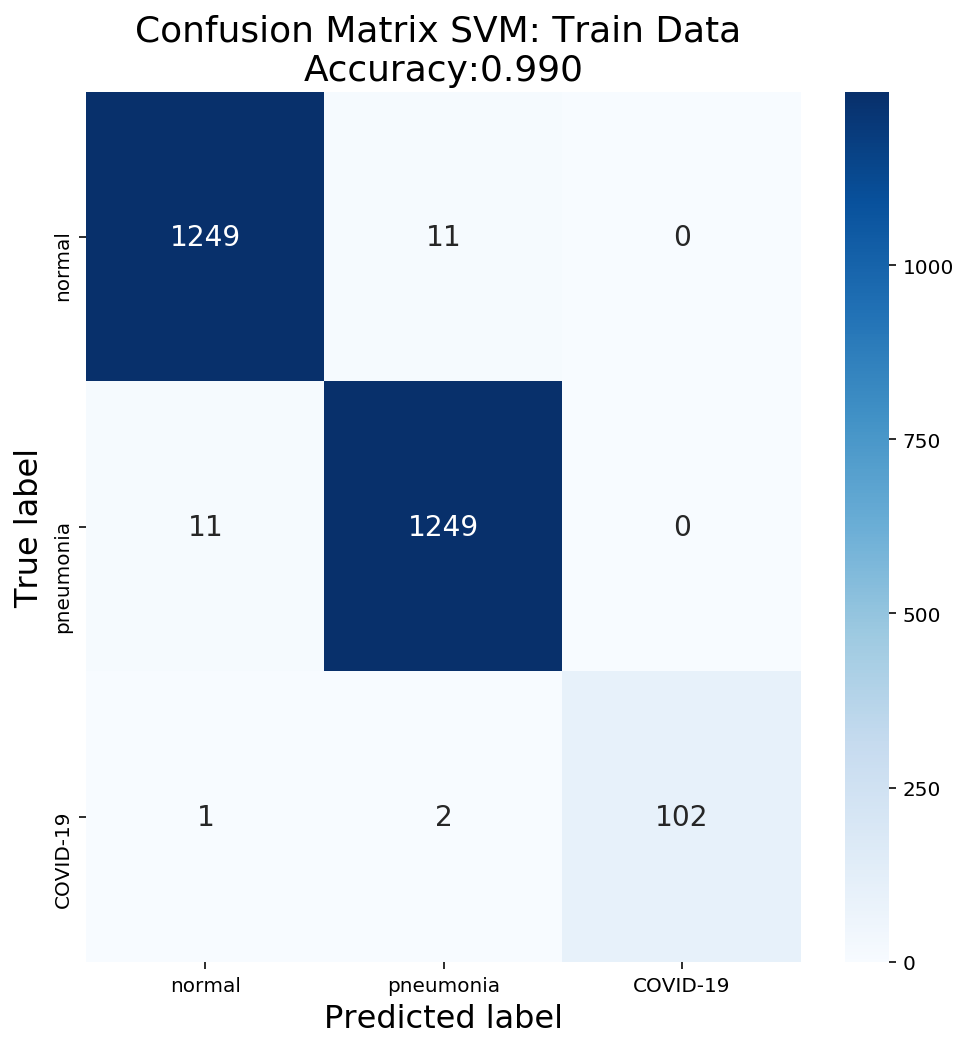

In [ ]:
plot_cm(y_train, svm_train, 'SVM: Train')

In [ ]:
svm_test = svm.predict(X_test.reshape(X_test.shape[0], -1))

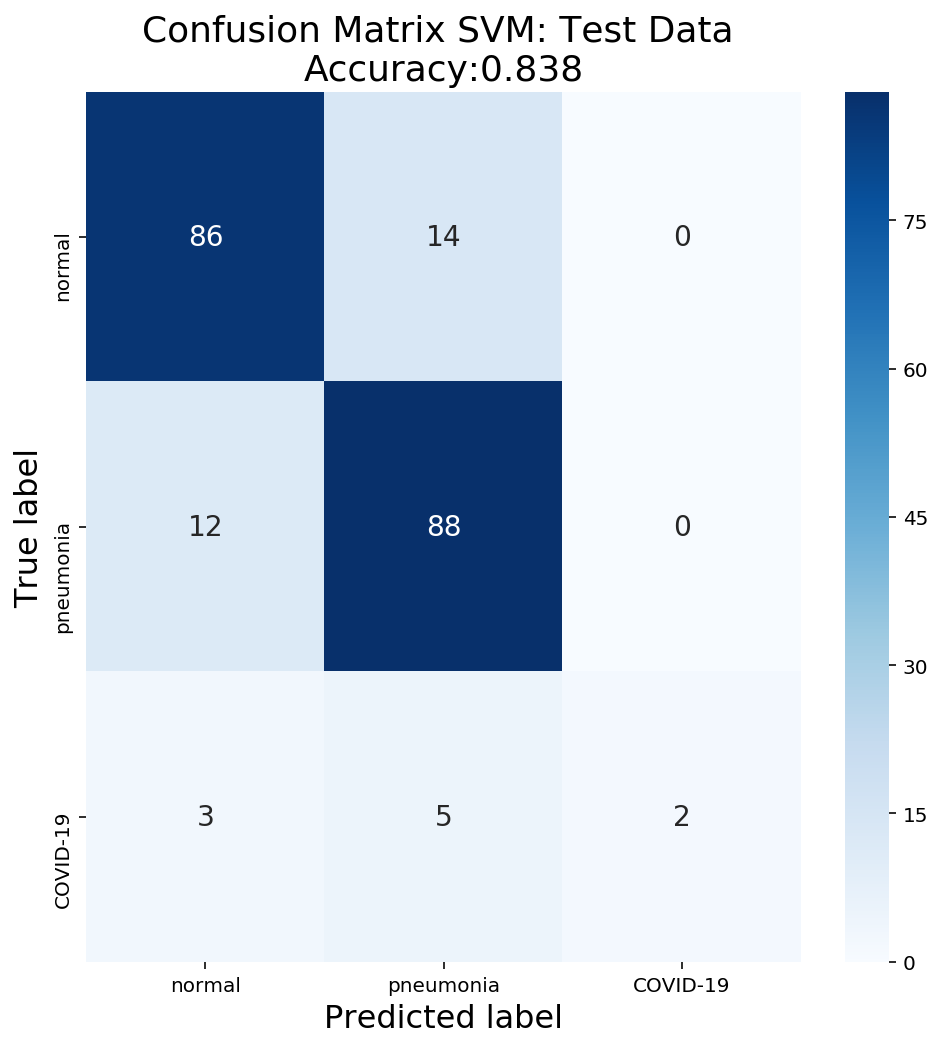

In [ ]:
plot_cm(y_test, svm_test, 'SVM: Test')

### Misclassifications

In [ ]:
y_probs_train = pd.read_csv('y_probs_train.csv', header = None)
y_probs_val = pd.read_csv('y_probs_val.csv', header = None)
y_probs_test = pd.read_csv('y_probs_test.csv', header = None)

In [ ]:
y_preds_train = np.argmax(np.array(y_probs_train), axis=1)

In [ ]:
y_preds_train = y_probs_train.idxmax(axis=1)
tp = pd.DataFrame(idx_val[(y_train == 0) & (y_preds_train.T == 0)])
tp = tp.sort_values(by = 0).values.ravel()
# pd.Series(cnn_scores)[tp].dropna().sort_values()

2625

In [ ]:
tp_cnn = pd.DataFrame(idx_val[(y_val == 1) & (cnn_preds.T == 1)])
tp_cnn = tp_cnn.sort_values(by = 0).values.ravel()
pd.Series(cnn_scores)[tp_cnn].dropna().sort_values()

### Model Summary 

In [ ]:
loaded_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________